In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [72]:
from lxml import etree
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch
import fiona
from itertools import chain

In [75]:
output = dict()
output['raw'] = []
output['lon'] = []
output['lat'] = []
    
for file in glob.glob('/Users/ofenton/data/garmin/activity_*.gpx'):
    tree = etree.parse(file)
    root = tree.getroot()

    for each in root.xpath('//ns:gpx/ns:trk/ns:trkseg/ns:trkpt', namespaces={'ns':'http://www.topografix.com/GPX/1/1'}):
        # check what we got back
        output['lon'].append(each.get('lon'))
        output['lat'].append(each.get('lat'))
        # now go back up to get the name
        r = each.getparent().getparent().xpath('ns:name', namespaces={'ns':'http://www.topografix.com/GPX/1/1'})[0]
        if isinstance(r.text, str):
            output['raw'].append(r.text.lstrip().rstrip())
        else:
            output['raw'].append(None)


In [76]:
df = pd.DataFrame(output)
df = df.replace({'raw': 0}, None)
df = df.dropna()
df[['lon', 'lat']] = df[['lon', 'lat']].astype(float)

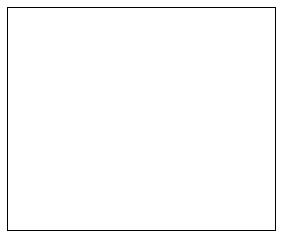

In [77]:
shp = fiona.open('data/london_wards.shp')
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

m = Basemap(
    projection='tmerc',
    lon_0=-2.,
    lat_0=49.,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)
m.readshapefile(
    'data/london_wards',
    'london',
    color='none',
    zorder=2)

# set up a map dataframe
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.london],
    'ward_name': [ward['NAME'] for ward in m.london_info]})
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000

# Create Point objects in map coordinates from dataframe lon and lat values
map_points = pd.Series(
    [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(df['lon'], df['lat'])])
cycling_points = MultiPoint(list(map_points.values))
wards_polygon = prep(MultiPolygon(list(df_map['poly'].values)))
# calculate points that fall within the London boundary
ldn_points = filter(wards_polygon.contains, cycling_points)

In [78]:
# Convenience functions for working with colour ramps and bars
def colorbar_index(ncolors, cmap, labels=None, **kwargs):
    """
    This is a convenience function to stop you making off-by-one errors
    Takes a standard colour ramp, and discretizes it,
    then draws a colour bar with correctly aligned labels
    """
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    if labels:
        colorbar.set_ticklabels(labels)
    return colorbar

def cmap_discretize(cmap, N):
    """
    Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)

    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki]) for i in xrange(N + 1)]
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)

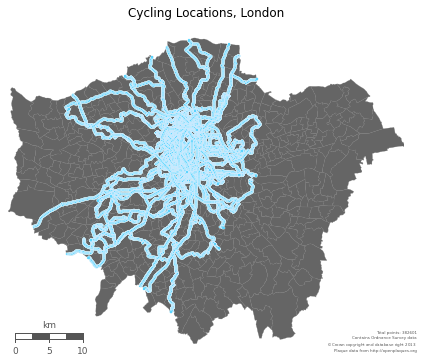

In [83]:
# draw ward patches from polygons
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x,
    fc='#555555',
    ec='#787878', lw=.25, alpha=.9,
    zorder=4))

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# we don't need to pass points to m() because we calculated using map_points and shapefile polygons
dev = m.scatter(
    [geom.x for geom in ldn_points],
    [geom.y for geom in ldn_points],
    5, marker='o', lw=.25,
    facecolor='#33ccff', edgecolor='w',
    alpha=0.9, antialiased=True,
    label='Blue Plaque Locations', zorder=3)
# plot boroughs by adding the PatchCollection to the axes instance
ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))
# copyright and source data info
smallprint = ax.text(
    1.03, 0,
    'Total points: %s\nContains Ordnance Survey data\n$\copyright$ Crown copyright and database right 2013\nPlaque data from http://openplaques.org' % len(ldn_points),
    ha='right', va='bottom',
    size=4,
    color='#555555',
    transform=ax.transAxes)

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.08, coords[1] + 0.015,
    coords[0], coords[1],
    10.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)
plt.title("Cycling Locations, London")
plt.tight_layout()
# this will set the image width to 722px at 100dpi
fig.set_size_inches(7.22, 5.25)
plt.savefig('data/london_cycling.png', dpi=100, alpha=True)
plt.show()

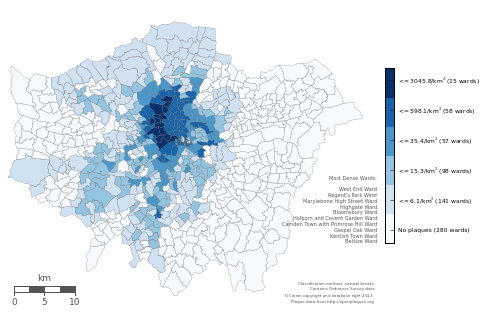

In [80]:
### PART 2 ###
df_map['count'] = df_map['poly'].map(lambda x: int(len(filter(prep(x).contains, ldn_points))))
df_map['density_m'] = df_map['count'] / df_map['area_m']
df_map['density_km'] = df_map['count'] / df_map['area_km']
# it's easier to work with NaN values when classifying
df_map.replace(to_replace={'density_m': {0: np.nan}, 'density_km': {0: np.nan}}, inplace=True)

# Calculate Jenks natural breaks for density
breaks = nb(
    df_map[df_map['density_km'].notnull()].density_km.values,
    initial=300,
    k=5)
# the notnull method lets us match indices when joining
jb = pd.DataFrame({'jenks_bins': breaks.yb}, index=df_map[df_map['density_km'].notnull()].index)
df_map = df_map.join(jb)
df_map.jenks_bins.fillna(-1, inplace=True)

jenks_labels = ["<= %0.1f/km$^2$(%s wards)" % (b, c) for b, c in zip(
    breaks.bins, breaks.counts)]
jenks_labels.insert(0, 'No plaques (%s wards)' % len(df_map[df_map['density_km'].isnull()]))

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# use a blue colour ramp - we'll be converting it to a map using cmap()
cmap = plt.get_cmap('Blues')
# draw wards with grey outlines
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#555555', lw=.2, alpha=1., zorder=4))
pc = PatchCollection(df_map['patches'], match_original=True)
# impose our colour map onto the patch collection
norm = Normalize()
pc.set_facecolor(cmap(norm(df_map['jenks_bins'].values)))
ax.add_collection(pc)

# Add a colour bar
cb = colorbar_index(ncolors=len(jenks_labels), cmap=cmap, shrink=0.5, labels=jenks_labels)
cb.ax.tick_params(labelsize=6)

# Show highest densities, in descending order
highest = '\n'.join(
    value[1] for _, value in df_map[(df_map['jenks_bins'] == 4)][:10].sort().iterrows())
highest = 'Most Visited Wards:\n\n' + highest
# Subtraction is necessary for precise y coordinate alignment
details = cb.ax.text(
    -1., 0 - 0.007,
    highest,
    ha='right', va='bottom',
    size=5,
    color='#555555')

# Bin method, copyright and source data info
smallprint = ax.text(
    1.03, 0,
    'Classification method: natural breaks\nContains Ordnance Survey data\n$\copyright$ Crown copyright and database right 2013\n,
    ha='right', va='bottom',
    size=4,
    color='#555555',
    transform=ax.transAxes)

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.08, coords[1] + 0.015,
    coords[0], coords[1],
    10.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)
# this will set the image width to 722px at 100dpi
plt.tight_layout()
fig.set_size_inches(7.22, 5.25)
plt.savefig('data/london_cycling_density.png', dpi=100, alpha=True)
plt.show()

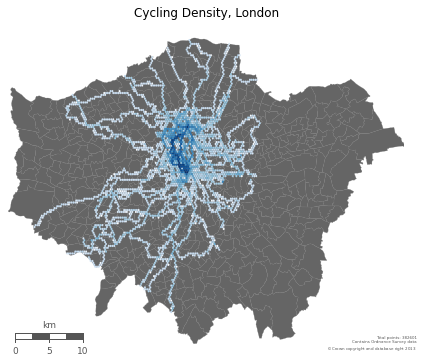

In [81]:
# draw ward patches from polygons
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, fc='#555555', ec='#787878', lw=.25, alpha=.9, zorder=0))

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# plot boroughs by adding the PatchCollection to the axes instance
ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))

df_london = df[
   (df['lon'] >= ll[0]) &
   (df['lon'] <= ur[0]) &
   (df['lat'] >= ll[1]) &
   (df['lat'] <= ur[1])
]

lon_ldn = df_london.lon.values
lat_ldn = df_london.lat.values

# the mincnt argument only shows cells with a value >= 1
# hexbin wants np arrays, not plain lists
hx = m.hexbin(
    np.array([geom.x for geom in ldn_points]),
    np.array([geom.y for geom in ldn_points]),
    gridsize=125,
    bins='log',
    mincnt=1,
    edgecolor='none',
    alpha=1.,
    lw=0.2,
    cmap=plt.get_cmap('Blues'))

# copyright and source data info
smallprint = ax.text(
    1.03, 0,
    'Total points: %s\nContains Ordnance Survey data\n$\copyright$ Crown copyright and database right 2013' % len(ldn_points),
    ha='right', va='bottom',
    size=4,
    color='#555555',
    transform=ax.transAxes
)

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.08, coords[1] + 0.015,
    coords[0], coords[1],
    10.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5
)
plt.title("Cycling Density, London")
plt.tight_layout()
fig.set_size_inches(8.47, 5.25)
plt.savefig('data/london_cycling_kde.png', dpi=300, alpha=True)
plt.show()